# Customer Journey Analysis using the Retailrocket Dataset

GitHub: https://github.com/revanth-muppana/CS5632-Final

## 1. Project Overview and Problem Statement

**Problem Description:**  
In today’s competitive e-commerce world, understanding how users navigate and interact with a website is crucial for optimizing user experience and marketing strategies. This project leverages unsupervised learning techniques to analyze customer journeys using the Retailrocket dataset. By clustering user sessions based on events such as page view, addtocart, and transaction (sourced from events.csv), we aim to uncover hidden patterns and identify distinct behavioral archetypes.

**Learning Task:**  
Unsupervised Learning – Clustering, Dimensionality Reduction, and Association Analysis

**Project Goal:**  
The goal is to segment user sessions into meaningful clusters that reflect different engagement levels and navigation styles. The insights can help e-commerce businesses tailor marketing strategies, optimize site design, and offer personalized recommendations.

## 2. Data Source and Description

**Dataset:**  
There are multiple files in the Retailrocket dataset:
- **events.csv:** Contains detailed logs of user interactions (e.g., page view, addtocart, transaction) along with visitor IDs, timestamps, and item IDs.
- **category_tree.csv:** Provides category information
- **item_properties_part1.csv & item_properties_part2.csv:** Contain additional item attributes.
- 

**Data Description (based on events.csv):**  
- **Observations:**  The file contains over 2 million rows.
- **Key Features:**
    - `visitorid`: A unique identifier for each user (string or integer).  
     - `timestamp`: A Unix timestamp (in seconds or milliseconds) that indicates when the event occurred.  
     - `event`: A categorical variable describing the event type (e.g., `view`, `addtocart`, `transaction`).  
     - `itemid`: An identifier for the item/product involved in the event. 
     - `transactionid`: Unique identifier of the transaction (non empty only for transaction event type).
- **Data Structure:**  
  Although the data is in a single table (events.csv), its sequential nature—where multiple events form a complete session—is key for understanding customer journeys.

**Citation (APA):**  
Retailrocket Recommender System Dataset. (n.d.). Retrieved from https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset

**Why This Dataset?**  
The dataset offers detailed user interaction logs that are ideal for uncovering hidden patterns in customer behavior through unsupervised learning.

## 3. Data Loading and Cleaning

**Objective:**  
Before performing any analysis, it’s important to clean the data.
- Load the main events dataset.
- Check data types and handle missing values.
- Convert the timestamp column to a datetime object and extract additional time-based features.
- Group events by visitorid to generate session-level features.

**Plan:**  
1. Load events.csv.
2. Inspect the data and clean up missing or inconsistent values.
3. Create new features (e.g., hour, day).
4. Aggregate data to form session summaries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from scipy.cluster.hierarchy import linkage, dendrogram
import warnings

warnings.filterwarnings("ignore")

### Load the Dataset

We will load the events.csv file which is our primary data source for customer journey analysis.

In [ ]:
# Load events.csv
df = pd.read_csv('/kaggle/input/ecommerce-dataset/events.csv')
print("Events dataset loaded successfully!")
print("Shape of the events dataset:", df.shape)
df.head()

Events dataset loaded successfully!
Shape of the events dataset: (2756101, 5)


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


### Initial Data Inspection and Cleaning

First, we check data types and look for missing values. The `timestamp` column is converted into a datetime object, and we extract additional features such as the hour and day of the week.

In [ ]:
print(df.info())

# Identify missing values
missing_values = df.isnull().sum()
print("\nMissing values in each column:\n", missing_values[missing_values > 0])

# Convert 'timestamp' to datetime
if not np.issubdtype(df['timestamp'].dtype, np.datetime64):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
# Drop rows with invalid timestamps
df = df.dropna(subset=['timestamp'])

# Extract additional time-based features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.dayofweek  # Monday=0, Sunday=6

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB
None

Missing values in each column:
 transactionid    2733644
dtype: int64


### Visitor-Based Feature Engineering

To analyze customer journeys, we group events by `visitorid`. For each visitor, we compute:
- **Event Count:** Total number of events by the visitor.
- **Session Duration:** Difference between the first and last event of that visitor.
- **Average Session Hour:** The mean hour at which events occurred.
- **Event Type Counts:** Total number of addtocart, view, and transaction.

These visitor-level features will serve as the basis for our clustering analysis.

In [ ]:
# Convert visitorid to string if not already
df['visitorid'] = df['visitorid'].astype(str)

# Group data by visitorid
visitor_groups = df.groupby('visitorid')

# Create a DataFrame for visitor-level features
visitor_df = pd.DataFrame()

# Count events by type for each visitor
visitor_df = visitor_groups.agg(
    event_count=('event', 'size'),
    start_time=('timestamp', 'min'),
    end_time=('timestamp', 'max'),
    avg_hour=('hour', 'mean'),
    addtocart=('event', lambda x: (x == 'addtocart').sum()),
    view=('event', lambda x: (x == 'view').sum()),
    transaction=('event', lambda x: (x == 'transaction').sum())
)

visitor_df['duration_min'] = (visitor_df['end_time'] - visitor_df['start_time']).dt.total_seconds() / 60

visitor_df.head()

,event_count,start_time,end_time,avg_hour,addtocart,view,transaction,duration_min
visitorid,,,,,,,,
0,3,2015-09-11 20:49:49.439,2015-09-11 20:55:17.175,20.0,0,3,0,5.462267
1,1,2015-08-13 17:46:06.444,2015-08-13 17:46:06.444,17.0,0,1,0,0.000000
10,1,2015-08-04 18:30:29.611,2015-08-04 18:30:29.611,18.0,0,1,0,0.000000
100,4,2015-09-08 23:48:55.990,2015-09-08 23:52:54.884,23.0,0,4,0,3.981567
1000,1,2015-07-05 13:38:36.161,2015-07-05 13:38:36.161,13.0,0,1,0,0.000000


## 4. Exploratory Data Analysis (EDA)

Next, we explore these visitor-level features to understand customer journey patterns. We'll examine:
- The distribution of visitor activity durations and event counts.
- Temporal patterns (like average activity hour) to see peak engagement.
- Correlations among features to understand relationships between different aspects of user behavior.

### Distribution of Duration and Event Counts

We plot histograms for the visitor's duration and the total number of events. This helps reveal if there are natural groupings, such as casual visitors versus highly engaged users.

In [ ]:
# Histogram for visitor duration
plt.figure()
sns.histplot(visitor_df['duration_min'])
plt.title("Distribution of Visitor Duration (minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.show()

# Histogram for event count per visitor
plt.figure()
sns.histplot(visitor_df['event_count'])
plt.title("Distribution of Event Count per Visitor")
plt.xlabel("Number of Events")
plt.ylabel("Frequency")
plt.show()

### Temporal Patterns in Visitor Activity

We plot the distribution of average activity hour to see when visitors are most active. This can help determine peak engagement times.

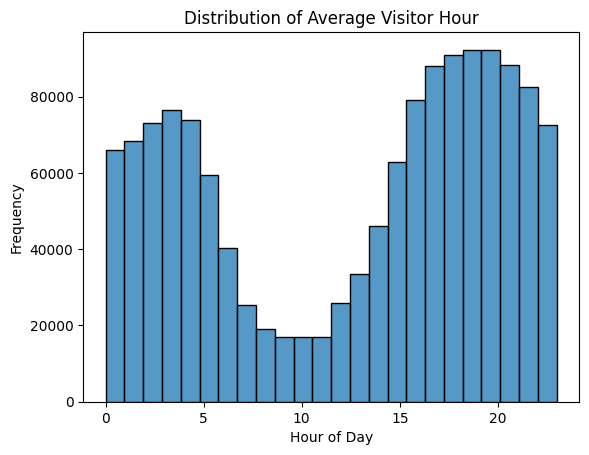

In [ ]:
plt.figure()
sns.histplot(visitor_df['avg_hour'], bins=24)
plt.title("Distribution of Average Visitor Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Frequency")
plt.show()

### Correlation among Visitor-Level Features

The correlation matrix helps us see how features like event count, duration, and specific event types are related. This insight informs our feature selection for clustering.

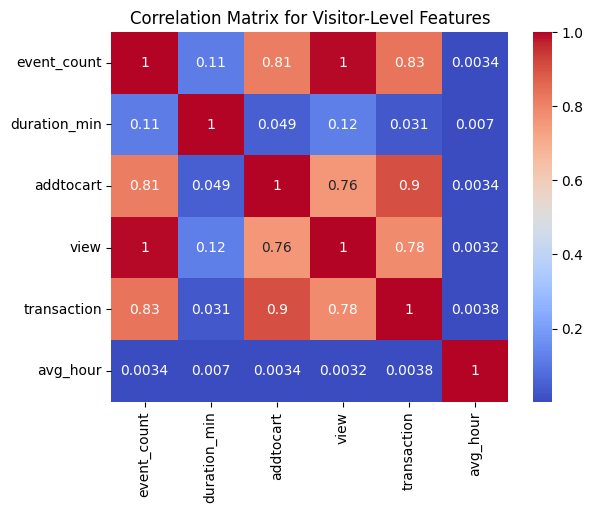

In [ ]:
corr = visitor_df[['event_count', 'duration_min', 'addtocart', 'view', 'transaction', 'avg_hour']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Visitor-Level Features")
plt.show()

**Goals of EDA**
- Understand the distribution of key variables (e.g., number of events per visitor, time spent).  
- Look for potential data imbalances or anomalies (e.g., outliers with extremely high event counts).  
- Generate insights on how to structure or transform data for clustering.
                                                         
**Visualizations and Findings**:
**Histograms**  
 - We create histograms for `duration_min` and `event_count` to see if visitors mostly have short interactions or if there’s a long tail of highly engaged visitors.  
 - We note if the data is heavily right-skewed, which might motivate a log transform in some models.

**Correlation Matrix**  
 - We examine correlations among features like `addtocart`, `views`, `transaction`, `duration_min`, etc. A strong correlation between `views` and `clicks` might indicate that users who view many items also tend to click frequently.  
 - If we see very high correlation between certain features, we may consider dimension reduction or dropping redundant features.  

**Potential Issues Found**  
  - We check for extremely large durations (which might be an artifact of the data or a single visitor returning months later). We can decide whether to keep or filter them out depending on domain context.  

**Conclusion/Discussion**:  
- The EDA suggests that we have a long-tail distribution for both duration and event counts. We keep all visitors for the clustering but remain mindful that outliers might form their own cluster or distort results.  
- We do not see strong data imbalance in terms of event types (like only 10 transactions overall) that would require special treatment, but if we did, we would note it here.


## 5. Unsupervised Modeling and Analysis

Our next step is to segment the visitors into distinct clusters based on their behavior. We’ll:
- Select and scale our features.
- Apply K-Means clustering and determine the optimal number of clusters.
- Visualize the clusters using PCA.
- Profile the clusters to interpret different visitor behaviors.

**Features Used:**  
- Event count, duration, counts of addtocart, view, transaction, and average hour.

### Feature Selection and Scaling

We extract the chosen features from visitor_df and standardize them so each feature contributes equally to the clustering.

In [ ]:
features = visitor_df[['event_count', 'duration_min', 'addtocart', 'view', 'transaction', 'avg_hour']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

### K-Means Clustering and Optimal Cluster Determination

I applied K-Means clustering. To decide the best number of clusters, I used:
- The elbow method (plotting inertia).
- Silhouette scores to measure clustering quality.

This will help us determine a reasonable value for k.

In [ ]:
inertia = []
sil_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot inertia (Elbow Method)
plt.figure()
plt.plot(K_range, inertia, 'bo-')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

# Plot Silhouette Scores
plt.figure()
plt.plot(K_range, sil_scores, 'ro-')
plt.title("Silhouette Scores for K-Means")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

# Assume k=4 is optimal based on these plots.
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
visitor_df['cluster'] = kmeans.fit_predict(X_scaled)
print("K-Means Cluster distribution:")
print(visitor_df['cluster'].value_counts())

### Dimensionality Reduction for Visualization

Using PCA, we reduce the feature space to 2 dimensions so that we can visualize the clusters and see how well they separate.

In [ ]:
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X_scaled)
visitor_df['pca1'] = components[:, 0]
visitor_df['pca2'] = components[:, 1]

plt.figure()
sns.scatterplot(data=visitor_df, x='pca1', y='pca2', hue='cluster', palette='Set2')
plt.title("PCA of Visitor Features Colored by K-Means Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

### Cluster Profiling and Interpretation

Now, we profile each cluster by computing the average values of our features. This helps us understand what each cluster represents—for example, which clusters indicate short, low-engagement visits versus longer, highly interactive sessions.

In [ ]:
cluster_profiles = visitor_df.groupby('cluster').mean()[['event_count', 'duration_min', 'addtocart', 'view', 'transaction', 'avg_hour']]
print("Cluster Profiles:")
print(cluster_profiles)

## 6. Extended Clustering Analysis

To dive deeper into the data, I also applied Hierarchical Clustering to see the nested structure of clusters. This can help uncover more nuanced patterns in visitor behavior.

### Hierarchical Clustering and Dendrogram

I used Ward’s method to generate a dendrogram. This visually represents how visitor clusters merge and helps in understanding the data's inherent structure.

In [ ]:
linkage_matrix = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Sample index or Cluster size")
plt.ylabel("Distance")
plt.show()

## 7. Extended Discussion and Future Directions

**Summary of Findings:**  
The unsupervised analysis shows that visitor behavior naturally groups into distinct clusters. K-Means reveals that some visitors have low event counts and short durations (likely casual browsers), while others exhibit longer, highly interactive sessions (potential buyers or engaged users). Hierarchical clustering suggests a nested structure.

**Implications:**  
These insights are valuable for e-commerce businesses. For example, visitors with high engagement could be targeted for personalized promotions, while low-engagement visitors might benefit from site optimizations to boost interest. 

**Future Directions:**  
Future work could focus on refining feature engineering by incorporating additional data (such as item properties or category information from the other provided files), exploring more advanced clustering algorithms, or experimenting with deep learning methods like variational autoencoders. Ensemble clustering techniques might also help improve segmentation robustness.

**Conclusion:**  
This extended unsupervised analysis demonstrates that multiple clustering techniques can provide deep insights into visitor behavior. The clusters identified here lay a strong foundation for personalized marketing, website optimization, and further research in customer journey analysis.